# Assignment 3:

**Research question: "Build a recommendation system that recommend products each customer will purchase."**

**Members**:

- Nguyen Thi Quynh Giang - s386617
- Vo Gia Bao - s3823477
- Phan Ngoc Quang Anh - s3810148


<b>Methodologies Overview:</b>

<b>1. Collaborative Filtering RecSys based on RFM Analysis of purchase dataset of H&M <b>(transaction_train.csv)</b>:</b>

- This approach would purely consume the transaction_train.csv dataset to build User profile utilizing RFM technique.
- Data will be transformed accordingly to fit into pre-trained models provided by Surprise library.<br>

<b>2. Image-based content-based RecSys using 2 datasets: <b>articles.csv and article images:</b></b>

- The main dataset for this approach will be the images of articles, which will be the target to extract features from, using CNN ResNet50 model.
- articles.csv dataset will also be utilized, but more like for reference and mapping purposes for the images.
- We sampled approximately ~7300 articles and its images from the original dataset (which contains 105k records.)


# 0. Library import


In [201]:
# content-based filtering approach unzip files
# !unzip downscaled_images_raw.zip
# !unzip downscaled_images_structure.zip
# !unzip ResNet_Children_feature_product_ids.npy.zip
# !unzip ResNet_Children_features.npy.zip
# !unzip ResNet_Divided_feature_product_ids.npy.zip
# !unzip ResNet_Divided_features.npy.zip
# !unzip ResNet_Ladieswear_feature_product_ids.npy
# !unzip ResNet_Ladieswear_features.npy.zip
# !unzip ResNet_Menswear_feature_product_ids.npy.zip
# !unzip ResNet_Menswear_features.npy.zip
# !unzip ResNet_Sport_feature_product_ids.npy.zip
# !unzip ResNet_Sport_features.npy.zip
# !unzip transactions_train.csv.zip
# !unzip articles.csv.zip

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.metrics.pairwise import cosine_similarity
# collaborative filtering modeling
import pickle
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import SVD, NMF

# Image reprocessing and image extraction
import os
import cv2
import tensorflow as tf
import matplotlib.image as mpimg
from tensorflow import keras
from PIL import Image
from keras.layers import Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
# contant-based modeling imports
from sklearn.metrics import pairwise_distances
# visualy the evaluation algorithms
from prettytable import PrettyTable


%matplotlib inline

theme = ["#AF0848", "#E90B60", "#CB2170", "#954E93",
         "#705D98", "#5573A8", "#398BBB", "#00BDE3"]
sns.set_palette('icefire', n_colors=None, desat=None, color_codes=False)


# I. Data Overview


For the 2 recommender systems approaches that we decided to build, we will use 3 datasets out of 4 dataset provided in the Kaggle competition (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations).<br>

🛍️ **There are 2 metadata .csv files and 1 image dataset:**

- `images` - folder containing the photo of _almost_ all `article_ids`
- `articles.csv` - description features of all `article_ids` **(105,542 datapoints)**
- `transactions_train.csv` - file containing the `customer_id`, the article that was bought and at what price **(31,788,324 datapoints)**


## 1. Article data


Article data is detailed metadata for each article_id available for purchase


### 1.1. Import article dataset


In [203]:
articles = pd.read_csv("articles.csv")
articles.head(10)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
5,110065011,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,12,Light Beige,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
6,111565001,111565,20 den 1p Stockings,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo..."
7,111565003,111565,20 den 1p Stockings,302,Socks,Socks & Tights,1010016,Solid,13,Beige,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny nylon stockings with a wide, reinfo..."
8,111586001,111586,Shape Up 30 den 1p Tights,273,Leggings/Tights,Garment Lower body,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,Tights with built-in support to lift the botto...
9,111593001,111593,Support 40 den 1p Tights,304,Underwear Tights,Socks & Tights,1010016,Solid,9,Black,...,Tights basic,B,Lingeries/Tights,1,Ladieswear,62,"Womens Nightwear, Socks & Tigh",1021,Socks and Tights,"Semi shiny tights that shape the tummy, thighs..."


### 1.2. Article data Overview


In [204]:
articles.dtypes


article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

<!-- <style>
ul {
  list-style-type: none;
  padding: 0;
  margin: 0;
}

li {
  font-family: Arial, sans-serif;
  font-size: 16px;
  padding: 10px;
  margin-bottom: 5px;
  background-color: #f9f9f9;
  border-radius: 5px;
}
</style> -->

<ul>
  <li>article_id: an integer data type, which serves as a unique identifier for each article.</li>
  <li>product_code: an integer data type, which is used to represent the code of a product.</li>
  <li>prod_name: an object data type, which is used to store the name of a product.</li>
  <li>product_type_no: an integer data type, which is used to represent the group of product_code.</li>
  <li>product_type_name: an object data type, which is used to store the name of the product group.</li>
  <li>product_group_name: an object data type, which is used to store the name of the product group.</li>
  <li>graphical_appearance_no: an integer data type, which is used to represent the group of graphics.</li>
  <li>graphical_appearance_name: an object data type, which is used to store the name of the graphic group.</li>
  <li>colour_group_code: an integer data type, which is used to represent the group of colors.</li>
  <li>colour_group_name: an object data type, which is used to store the name of the color group.</li>
  <li>perceived_colour_value_id: an integer data type, which is used to represent additional information about a color.</li>
  <li>perceived_colour_value_name: an object data type, which is used to store the name of color information.</li>
  <li>perceived_colour_master_id: an integer data type, which is used to represent the master information about a color.</li>
  <li>perceived_colour_master_name: an object data type, which is used to store the name of master color information.</li>
  <li>department_no: an integer data type, which is used to represent the department.</li>
  <li>department_name: an object data type, which is used to store the name of the department.</li>
  <li>index_code: an object data type, which is used to represent the code of index.</li>
  <li>index_name: an object data type, which is used to store the name of the index.</li>
  <li>index_group_no: an integer data type, which is used to represent the group of the index.</li>
  <li>index_group_name: an object data type, which is used to store the name of the index group.</li>
  <li>section_no: an integer data type, which is used to represent the section of data.</li>
  <li>section_name: an object data type, which is used to store the name of the section.</li>
  <li>garment_group_no: an integer data type, which is used to represent the group of the garment.</li>
  <li>garment_group_name: an object data type, which is used to store the name of the garment group.</li>
  <li>detail_desc: an object data type, which is used to store detailed information about the data.</li>
</ul>


#### 1.3. Data sampling method:


In [205]:
articles.shape


(105542, 25)

Taking a look at the <b>article images</b> folder structure from Kaggle (https://www.kaggle.com/competitions/h-and-m-personalized-fashion-recommendations/data), we can see that the images are grouped into sub-folders whose name is the first 3 characters of the <b>article_id</b> and the image name is the <b>article_id</b>.
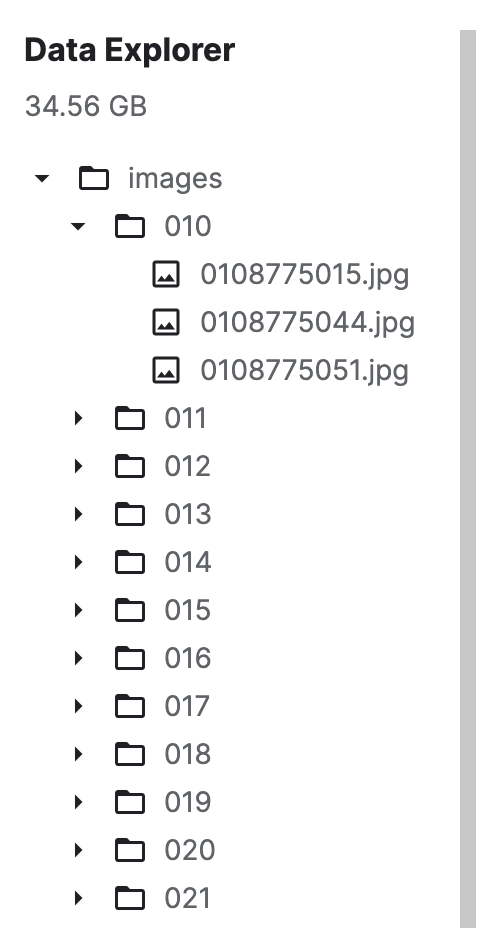


Since the original article data contains over 105k samples, we could not use this dataset for modeling as we do not have enough computing resources. The way we approach sampling article data that will also match the articles images is to get a set of consecutive records using column article_id. At the same time we will also select the folders of images respective to the range of <b>article_id</b>.

Here we decided to select articles sameple in range 290000000 -> 520000000. Then the images folders selected will be from subfolder named 029 to subfolder named 051.


In [206]:
small_articles_df = articles[(articles['article_id'] >= 290000000) & (
    articles['article_id'] < 520000000)]


## 2. Transaction Dataset

### 2.1. Import Dataset


In [207]:
transactions = pd.read_csv("transactions_train.csv")
transactions.head()


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


### 2.2 Transaction Dataset overview


In [208]:
transactions.dtypes


t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
dtype: object

<ul>
  <li>The dataset includes the following variables and their data types:</li>
    <ul>
      <li>t_dat, a variable of type object capturing the transaction date</li>
      <li>customer_id, a unique identifier of type object</li>
      <li>article_id, a unique identifier of type integer</li>
      <li>price, the monetary value associated with the transaction of type float</li>
      <li>sales_channel_id, a categorical variable identifying the sales channel involved in the transaction, taking on integer values.</li>
    </ul>
</ul>


From the provided dataset, we need to group the customer by "customer_id" then find the top 50 customers who spent most to apply the RFM analysis in the future.


In [209]:
top_customer = transactions.groupby('customer_id').count(
).sort_values(by='price', ascending=False)['price']
top_customer[0:50]


customer_id
be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b    1895
b4db5e5259234574edfff958e170fe3a5e13b6f146752ca066abca3c156acc71    1441
49beaacac0c7801c2ce2d189efe525fe80b5d37e46ed05b50a4cd88e34d0748f    1364
a65f77281a528bf5c1e9f270141d601d116e1df33bf9df512f495ee06647a9cc    1361
cd04ec2726dd58a8c753e0d6423e57716fd9ebcf2f14ed6012e7e5bea016b4d6    1237
55d15396193dfd45836af3a6269a079efea339e875eff42cc0c228b002548a9d    1208
c140410d72a41ee5e2e3ba3d7f5a860f337f1b5e41c27cf9bda5517c8774f8fa    1170
8df45859ccd71ef1e48e2ee9d1c65d5728c31c46ae957d659fa4e5c3af6cc076    1169
03d0011487606c37c1b1ed147fc72f285a50c05f00b9712e0fc3da400c864296    1157
6cc121e5cc202d2bf344ffe795002bdbf87178054bcda2e57161f0ef810a4b55    1143
e34f8aa5e7c8c258523ea3e5f5f13168b6c21a9e8bffccd515dd5cef56126efb    1117
3493c55a7fe252c84a9a03db338f5be7afbce1edbca12f3a908fac9b983692f2    1115
0bf4c6fd4e9d33f9bfb807bb78348cbf5c565846ff4006acf5c1b9aea77b0e54    1099
e6498c7514c61d3c24669f49753dc83fdff3ec1

# II. Data preparation


## 1. Article Dataset

#### 1.1. Check duplicate rows

In [278]:
small_articles_df.isna().any()

article_id                      False
product_code                    False
prod_name                       False
product_type_no                 False
product_type_name               False
product_group_name              False
graphical_appearance_no         False
graphical_appearance_name       False
colour_group_code               False
colour_group_name               False
perceived_colour_value_id       False
perceived_colour_value_name     False
perceived_colour_master_id      False
perceived_colour_master_name    False
department_no                   False
department_name                 False
index_code                      False
index_name                      False
index_group_no                  False
index_group_name                False
section_no                      False
section_name                    False
garment_group_no                False
garment_group_name              False
detail_desc                      True
dtype: bool

In [210]:
# check duplicates
small_articles_df.duplicated().any()


False

The dataset does not contain any duplicated rows.


### 1.2. Check article with no images


In [211]:
# Set the input directory
input_dir = 'downscaled_images_raw/'

# # Get a list of the images in the input directory
image_folders = os.listdir(input_dir)
image_names = []

# # Iterate over the images
for folder in image_folders:
    # Load the image
    image_filenames = os.listdir(input_dir+folder)
    for filename in image_filenames:
        image_names.append(int(filename[0:10]))

print("Number of unique images: " + str(len(image_names)))
print("Number of unique article ids: " + str(small_articles_df.shape[0]))


Number of unique images: 7324
Number of unique article ids: 7405


<p>There is an inconsistent between the number of articles and the number of images even though they are sampled in groups. To be specific, number of images are <b style="color: #CB1C8D">81 item less</b> than the row count of article.csv. This implies that some are products in <b style="color: #CB1C8D">article.csv</b> do not have images associated with them.</p>

We will drop these records as to some extent, they are rows with NaN values.


In [212]:
# get a list of article ids in dataframe
ids = small_articles_df["article_id"].to_list()

article_without_images = []

for id in ids:
    if (id not in image_names):
        article_without_images.append(id)

print(article_without_images)


[324963030, 348657006, 357792006, 364409037, 369423002, 369423004, 388916001, 395864048, 396135047, 396135048, 396690010, 397376010, 398947001, 405310006, 408875001, 408875002, 408875010, 411565004, 419634007, 419634010, 419634013, 420264002, 425683012, 438702006, 442786001, 443262014, 446224011, 446224013, 453065011, 460363012, 461414009, 461414010, 468666002, 469039021, 469658014, 470985008, 470985010, 475791011, 475827007, 480076004, 481777003, 481797022, 481797026, 481797027, 484864002, 485673022, 485678030, 485678032, 485973011, 486639004, 487926002, 489758004, 490275001, 490473012, 491912034, 494030013, 496762004, 499802028, 504152001, 504152008, 504960001, 504960003, 506177002, 507399003, 508931033, 510415003, 510504001, 511653001, 512300003, 512964002, 513701002, 515074002, 516550001, 516898002, 517724002, 517729011, 517729015, 517729030, 519219008, 519815003, 519987002]


In [213]:
small_articles_df = small_articles_df[~small_articles_df["article_id"].isin(
    article_without_images)]
small_articles_df.shape


(7324, 25)

The number of samples and images are now equal to each other.


### 1.3. Values rename

Since the column **index_group_name** of this dataset will be used later on for metadata-based image grouping, we will rename some values to make it more convenient for that task.

In [214]:
small_articles_df['index_group_name'].replace("Children/Baby", "Children", inplace=True)

## 2. Transaction Dataset:


### 2.1. Outliers detection and removal:

We need explore the distribution of price and the presence of outliers in the transactions dataset.


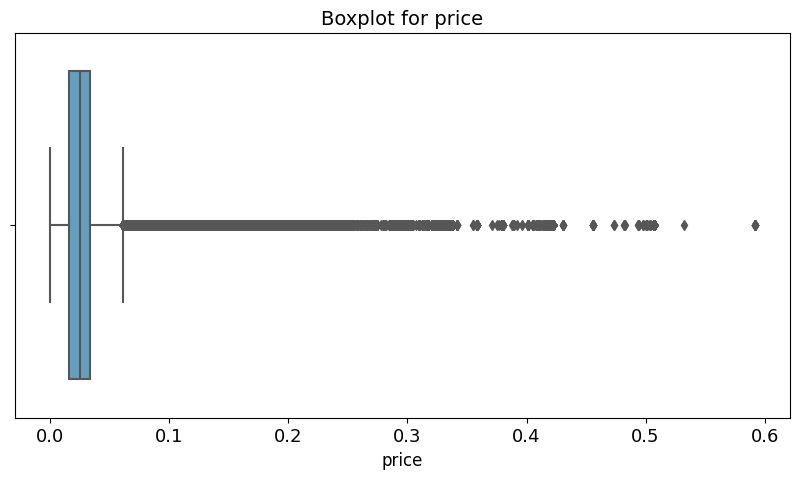

In [215]:
f, ax = plt.subplots(figsize=(10, 5))


def plot_boxplots(col, df, param_axis):
    sns.boxplot(x=col, data=df, ax=param_axis)
    param_axis.set_xlabel(param_axis.get_xlabel(), fontsize=12)
    param_axis.tick_params(axis='both', which='major', labelsize=13)
    param_axis.set_title('Boxplot for ' + col, fontsize=14)
    plt.ticklabel_format(style='plain', axis='x')


plot_boxplots('price', transactions, ax)


# III. Data exploration:


## 1. Article Dataset:

#### 1.3.1 Categorical features


We have unique values of categorical columns as the following:


In [216]:
for col in articles.columns:
    if not 'no' in col and not 'code' in col and not 'id' in col:
        unique_number = articles[col].nunique()
        print(f'number of unique {col}: {unique_number}')


number of unique prod_name: 45875
number of unique product_type_name: 131
number of unique product_group_name: 19
number of unique graphical_appearance_name: 30
number of unique colour_group_name: 50
number of unique perceived_colour_value_name: 8
number of unique perceived_colour_master_name: 20
number of unique department_name: 250
number of unique index_name: 10
number of unique index_group_name: 5
number of unique section_name: 56
number of unique garment_group_name: 21
number of unique detail_desc: 43404


#### 1.3.2 Key features

We select garment_group_name and index_group_name as these two features were chosen for analysis because they encapsulate a distinct separation of the articles into distinct categories


Text(0.5, 0, 'count')

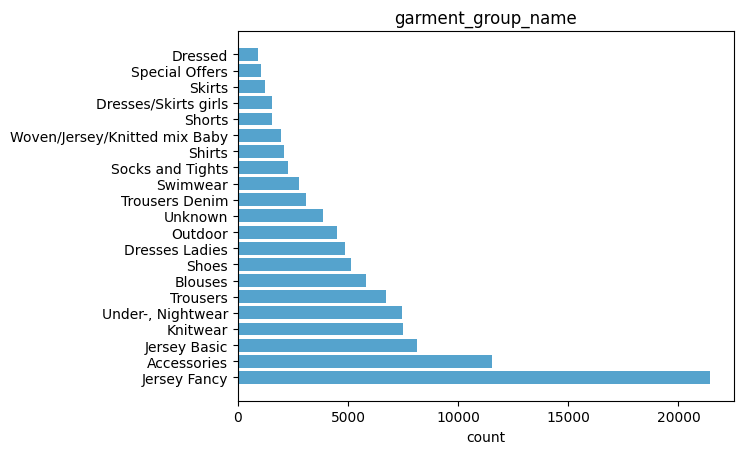

In [217]:
group_counts = articles['garment_group_name'].value_counts()
description_counts = articles['index_group_name'].value_counts()

plt.barh(group_counts.index, group_counts.values)
plt.title('garment_group_name')
plt.xlabel('count')


Text(0.5, 0, 'count')

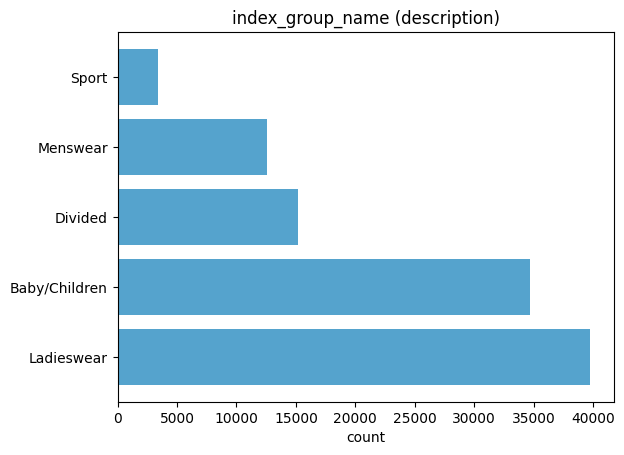

In [218]:
plt.barh(description_counts.index, description_counts.values)
plt.title('index_group_name (description)')
plt.xlabel('count')


Text(0, 0.5, 'garment group')

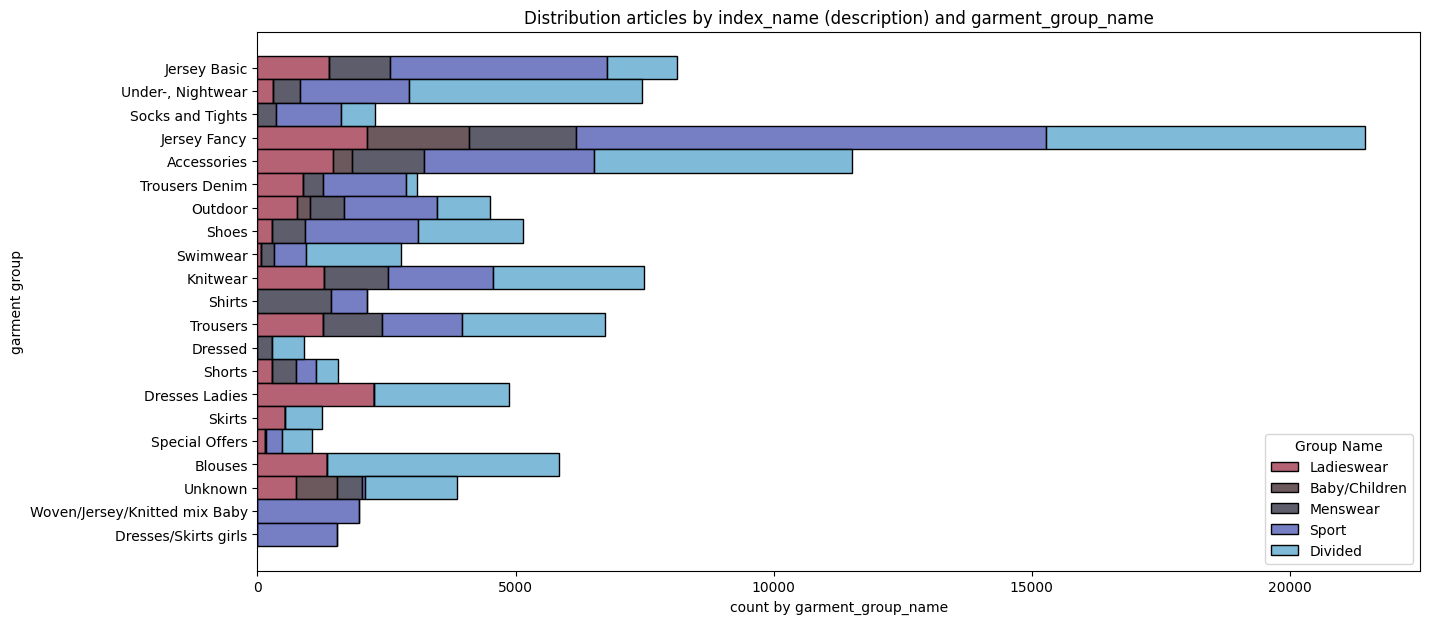

In [219]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=articles, y='garment_group_name',
                  hue='index_group_name', multiple="stack")
plt.title("Distribution articles by index_name (description) and garment_group_name")
plt.legend(title='Group Name', labels=[
           'Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'])
ax.set_xlabel('count by garment_group_name')
ax.set_ylabel('garment group')


We have a quantitative analysis of the distribution of articles was conducted by utilizing garment_group_name and index_group_name as categorical variables, providing insights into the frequency of occurrence for each group


In [220]:
garment_index_count = articles.groupby(
    ['garment_group_name', 'index_group_name']).count()['article_id']
for i in range(len(garment_index_count)):
    print(f'{garment_index_count.index[i]}:{garment_index_count[i]}')


('Accessories', 'Baby/Children'):3293
('Accessories', 'Divided'):1458
('Accessories', 'Ladieswear'):4999
('Accessories', 'Menswear'):1388
('Accessories', 'Sport'):381
('Blouses', 'Divided'):1346
('Blouses', 'Ladieswear'):4492
('Dressed', 'Ladieswear'):624
('Dressed', 'Menswear'):284
('Dresses Ladies', 'Divided'):2267
('Dresses Ladies', 'Ladieswear'):2607
('Dresses/Skirts girls', 'Baby/Children'):1541
('Jersey Basic', 'Baby/Children'):4193
('Jersey Basic', 'Divided'):1381
('Jersey Basic', 'Ladieswear'):1359
('Jersey Basic', 'Menswear'):1193
('Jersey Fancy', 'Baby/Children'):9103
('Jersey Fancy', 'Divided'):2128
('Jersey Fancy', 'Ladieswear'):6163
('Jersey Fancy', 'Menswear'):2077
('Jersey Fancy', 'Sport'):1974
('Knitwear', 'Baby/Children'):2038
('Knitwear', 'Divided'):1296
('Knitwear', 'Ladieswear'):2917
('Knitwear', 'Menswear'):1239
('Outdoor', 'Baby/Children'):1794
('Outdoor', 'Divided'):770
('Outdoor', 'Ladieswear'):1025
('Outdoor', 'Menswear'):664
('Outdoor', 'Sport'):248
('Shirts',

A quantitative analysis of the distribution of articles was conducted by utilizing index_group_name and index_name as categorical variables, providing insights into the frequency of occurrence for each group and subgroup respectivel.


In [221]:
articles.groupby(['index_group_name', 'index_name']).count()['article_id']


index_group_name  index_name                    
Baby/Children     Baby Sizes 50-98                   8875
                  Children Accessories, Swimwear     4615
                  Children Sizes 134-170             9214
                  Children Sizes 92-140             12007
Divided           Divided                           15149
Ladieswear        Ladies Accessories                 6961
                  Ladieswear                        26001
                  Lingeries/Tights                   6775
Menswear          Menswear                          12553
Sport             Sport                              3392
Name: article_id, dtype: int64

## 2. Transactions dataset


#### 2.1. Highly Purchased Articles:


Top 10 most-buy articles


In [222]:
purchases_counts = transactions['article_id'].value_counts().reset_index()
purchases_counts.columns = ['article_id', 'purchases']
purchases_counts.head(10)


,article_id,purchases
0,706016001,50287
1,706016002,35043
2,372860001,31718
3,610776002,30199
4,759871002,26329
5,464297007,25025
6,372860002,24458
7,610776001,22451
8,399223001,22236
9,706016003,21241


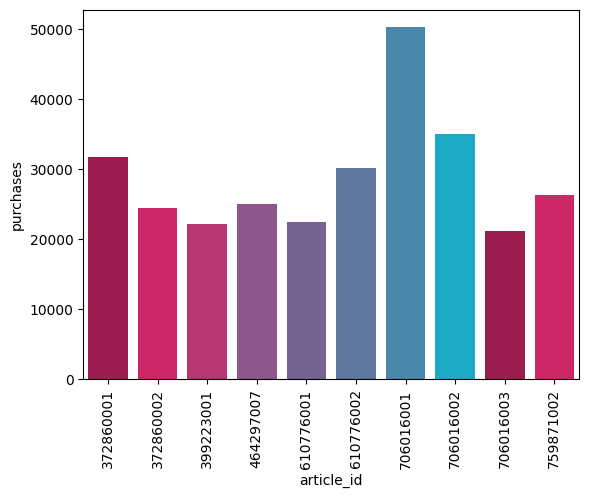

In [223]:
sns.barplot(x = 'article_id',
            y = 'purchases',
            data = purchases_counts.head(10),
            palette=theme)
plt.xticks(rotation=90)
plt.show()

In [224]:
category = []
for id in set(purchases_counts["article_id"].head(100)):
    category.append(articles[articles['article_id']== id]["index_group_name"].values[0])

category_df= pd.DataFrame()
category_df["category"] = category
category_df.value_counts()

category  
Ladieswear    70
Divided       22
Menswear       4
Sport          4
dtype: int64

<b style="color: #AF0848 ">Observation:</b> Among the top 100 most-buy products, 92% of them have index_group_name of Ladieswear and Divided. More specifically, Ladieswear are the most popular ones as it occupies 70% of the most popular products.

#### 2.2. Top Customer By Purchases:

In [225]:
customer_purchase_count = transactions['customer_id'].value_counts().reset_index()
customer_purchase_count.columns  = ['customer_id', 'items_purchased']

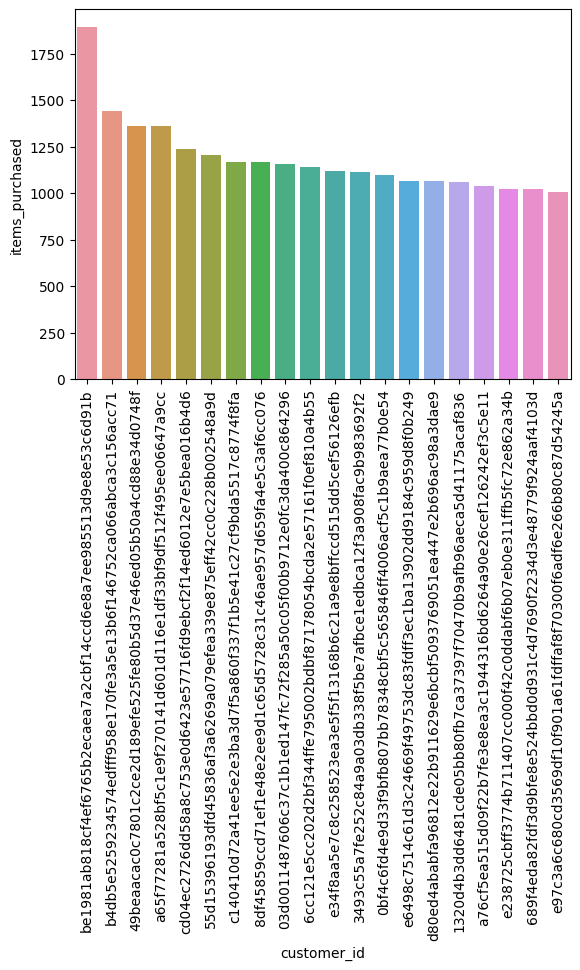

In [226]:
sns.barplot(x = 'customer_id',
            y = 'items_purchased',
            data = customer_purchase_count.head(20))
plt.xticks(rotation=90)
plt.show()

<b style="color: #AF0848 ">Observation:</b> The top customer bought as many as >1750 purchases.

## 3. Images

Example of the most expensive product images and their descreption.

In [302]:
left_join_transaction = transactions.merge(small_articles_df, on='article_id', how='left')

left_join_transaction.dropna(inplace=True)
max_price_ids = transactions[transactions.t_dat==transactions.t_dat.max()].sort_values('price', ascending=False).iloc[:5][['article_id', 'price']]
min_price_ids = transactions[transactions.t_dat==transactions.t_dat.min()].sort_values('price', ascending=True).iloc[:5][['article_id', 'price']]

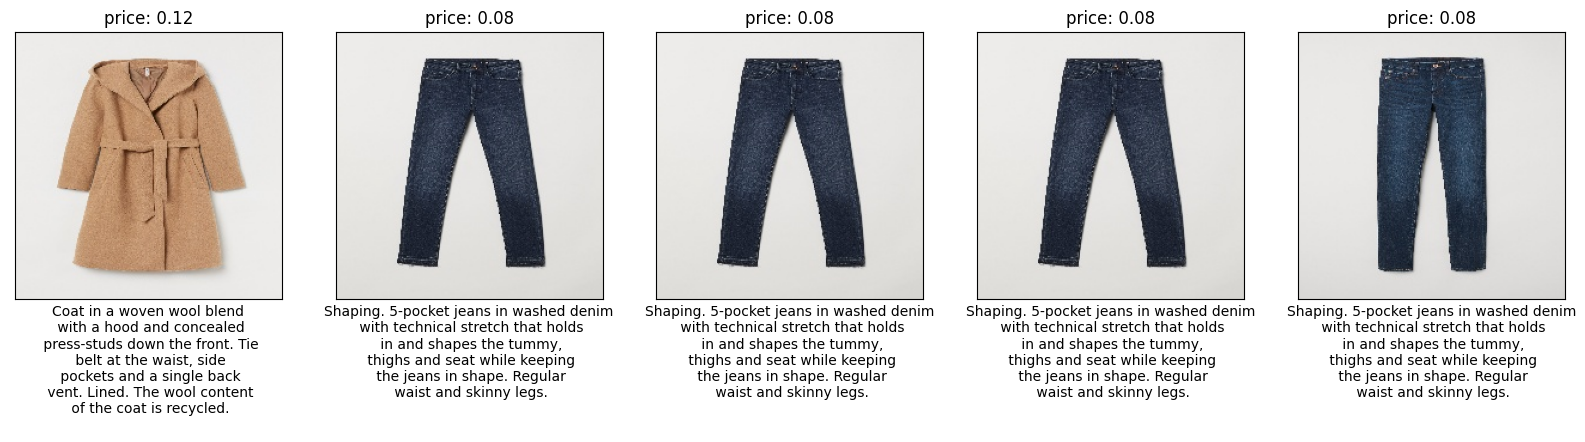

In [303]:
f, ax = plt.subplots(1, 5, figsize=(20,10))
i = 0

max_price_ids = left_join_transaction[left_join_transaction.t_dat==left_join_transaction.t_dat.max()].sort_values('price', ascending=False).iloc[:5][['article_id', 'price']]
min_price_ids = left_join_transaction[left_join_transaction.t_dat==left_join_transaction.t_dat.min()].sort_values('price', ascending=True).iloc[:5][['article_id', 'price']]


for _, data in max_price_ids.iterrows():
    desc = small_articles_df[small_articles_df['article_id'] == data['article_id']]['detail_desc'].iloc[0]
    desc_list = desc.split(' ')
    for j, elem in enumerate(desc_list):
        if j > 0 and j % 5 == 0:
            desc_list[j] = desc_list[j] + '\n'
    desc = ' '.join(desc_list)
    img = mpimg.imread(f'downscaled_images_raw/0{str(data.article_id)[:2]}/0{int(data.article_id)}.jpg')
    ax[i].imshow(img)
    ax[i].set_title(f'price: {data.price:.2f}')
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].grid(False)
    ax[i].set_xlabel(desc, fontsize=10)
    i += 1
plt.show()

The cheapeast products and their description.

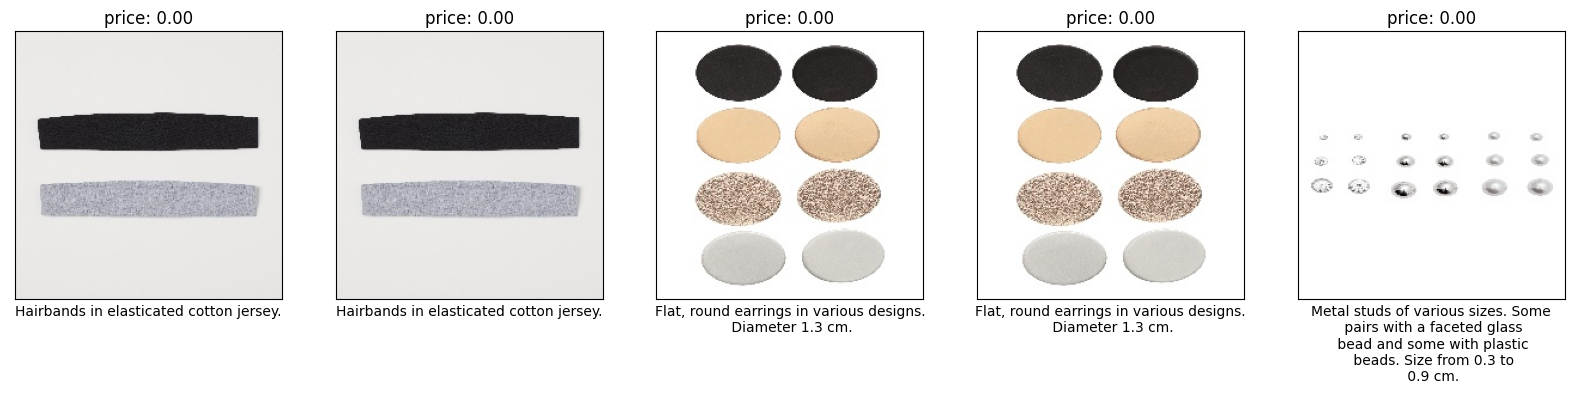

In [304]:
f, ax = plt.subplots(1, 5, figsize=(20,10))
i = 0

for _, data in min_price_ids.iterrows():
    desc = small_articles_df[small_articles_df['article_id'] == data['article_id']]['detail_desc'].iloc[0]
    desc_list = desc.split(' ')
    for j, elem in enumerate(desc_list):
        if j > 0 and j % 5 == 0:
            desc_list[j] = desc_list[j] + '\n'
    desc = ' '.join(desc_list)
    img = mpimg.imread(f'downscaled_images_raw/0{str(data.article_id)[:2]}/0{int(data.article_id)}.jpg')
    ax[i].imshow(img)
    ax[i].set_title(f'price: {data.price:.2f}')
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])
    ax[i].grid(False)
    ax[i].set_xlabel(desc, fontsize=10)
    i += 1
plt.show()

# IV. Building Recommendation System


## 1. Item-user Collaborative Filtering based on RFM customer profile

### 1.2. Data Preprocessing:

#### 1.2.1 Transaction data

The transformation of the variable t_dat to the variable InvoiceDate with the appropriate format for time series analysis to facilitate further processing. In addition, duplicate records were removed as they are not necessary


In [230]:
transactions['InvoiceDate'] = pd.to_datetime(
    transactions['t_dat'], format='%Y-%m-%d')
transactions = transactions[["InvoiceDate", "customer_id",
                             "article_id", "price", "sales_channel_id"]].drop_duplicates()
transactions.head().T


,0,1,2,3,4
InvoiceDate,2018-09-20 00:00:00,2018-09-20 00:00:00,2018-09-20 00:00:00,2018-09-20 00:00:00,2018-09-20 00:00:00
customer_id,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,00007d2de826758b65a93dd24ce629ed66842531df6699...,00007d2de826758b65a93dd24ce629ed66842531df6699...,00007d2de826758b65a93dd24ce629ed66842531df6699...
article_id,663713001,541518023,505221004,685687003,685687004
price,0.050831,0.030492,0.015237,0.016932,0.016932
sales_channel_id,2,2,2,2,2


We have an analysis of the transaction dataset was conducted to identify the distinct customers who have made purchases.


In [231]:
unique_customers = transactions['customer_id'].unique().tolist()
len(unique_customers)


1362281

The number of unique customers who made purchases is 1362281, while the total number of customers in the dataset is 1371980.


In [232]:
# The unique products or article_id
unique_articles = transactions['article_id'].unique().tolist()
len(unique_articles)


104547

The number of unique products that were the subject of transactions is 104547, in comparison to the total number of products in the dataset which is 105542.


#### 1.2.2 RFM Analysis


<b>Explain:</b> RFM (Recency, Frequency, Monetary) analysis and collaborative filtering are two different techniques that are often used in different scenarios but can be combined for an even better results in some cases, specifically in recommendations systems. For example, using RFM analysis, businesses can identify the most valuable customers, and then use collaborative filtering to recommend products to those customers that similar customers have also purchased.


In [233]:
start_date = datetime.datetime(2020, 3, 1)

# Filter transactions by date
transactions["t_dat"] = pd.to_datetime(transactions["InvoiceDate"])
transactions = transactions.loc[transactions["t_dat"] >= start_date]

# analysis_date = max(transactions['InvoiceDate']) + dt.timedelta(days= 1)
analysis_date = datetime.datetime(2020, 9, 23)

transactions['date'] = transactions['InvoiceDate']
(analysis_date - transactions['InvoiceDate'].max()).days

rfm = transactions.groupby('customer_id').agg({
    'InvoiceDate': lambda x: (analysis_date - x.max()).days,
    'date': 'count',
    'price': 'sum'})

rfm.head().T


customer_id,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a
InvoiceDate,18.000000,77.000000,8.000000,42.000000,9.000000
date,6.000000,10.000000,9.000000,7.000000,2.000000
price,0.144475,0.225254,0.413407,0.255814,0.076237


From the above RFM analysis, we could build a user-profile as follow


In [234]:
rfm.columns = ["Recency", "Frequency", "Monetary"]
rfm = rfm[rfm["Monetary"] > 0]
# the highest rank receives a score of 5 and the lowest receives a score of 1
rfm["recency_score"] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])

# the highest rank receives a score of 5 and the lowest receives a score of 1
rfm["frequency_score"] = pd.qcut(rfm["Frequency"].rank(
    method="first"), 5, labels=[1, 2, 3, 4, 5])

# the highest rank receives a score of 5 and the lowest receives a score of 1
rfm["monetary_score"] = pd.qcut(rfm["Monetary"], 5, labels=[1, 2, 3, 4, 5])

rfm.head().T


customer_id,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a
Recency,18.000000,77.000000,8.000000,42.000000,9.000000
Frequency,6.000000,10.000000,9.000000,7.000000,2.000000
Monetary,0.144475,0.225254,0.413407,0.255814,0.076237
recency_score,5.000000,3.000000,5.000000,4.000000,5.000000
frequency_score,3.000000,4.000000,4.000000,3.000000,1.000000
monetary_score,3.000000,4.000000,5.000000,4.000000,2.000000


In [235]:
# calculates the overall RFM score based on frequency and recency
rfm["RFM_SCORE"] = (rfm["recency_score"].astype(
    str) + rfm["frequency_score"].astype(str))


/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/pandas/core/arrays/categorical.py:555: RuntimeWarning: invalid value encountered in cast
  np.array(self.categories._na_value).astype(dtype)


<style>
ul {
  list-style-type: none;
  margin: 0;
  padding: 0;
  overflow: hidden;
  background-color: #333;
}

li {
  float: left;
}

li a {
  display: block;
  color: white;
  text-align: center;
  padding: 14px 16px;
  text-decoration: none;
}

li a:hover {
  background-color: #111;
}
</style>
<body>
    <div>We will separate the customer based on RFM score into several customer groups: </div>
<ul>
  <li><a>Hibernating: who have not made a purchase in a long time but have made purchases in the past</a></li>
  <li><a>At Risk: who have recently stopped making purchases or have reduced their spending</a></li>
  <li><a>Cant Loose: who have made significant purchases in the past and have a high lifetime value</a></li>
  <li><a>About To Sleep and Need attention: who have recently made a purchase but have not been active for some time</a></li>
  <li><a>Loyal customers: who have made frequent purchases over a long period of time</a></li>
  <li><a>Promising: those who have made recent purchases and have a high potential for future spending</a></li>
  <li><a>New customers: those who have recently made their first purchase</a></li>
<li><a>Potential loyalists: who have made recent purchases but have not yet reached the level of a loyal customer</a></li>
  <li><a>Champions: are the most valuable customers, who have made the most purchases and have the highest lifetime value</a></li>
</ul>

In [236]:
# define the customer segments
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head().T


customer_id,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657,0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa,000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801fe7fc0f26dd8d65a85a,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d8cd0c725276a467a2a
Recency,18,77,8,42,9
Frequency,6,10,9,7,2
Monetary,0.144475,0.225254,0.413407,0.255814,0.076237
recency_score,5,3,5,4,5
frequency_score,3,4,4,3,1
monetary_score,3,4,5,4,2
RFM_SCORE,53,34,54,43,51
segment,potential_loyalists,loyal_customers,champions,potential_loyalists,new_customers


In [237]:
# The description of the segments
rfm[["segment", "Recency", "Frequency", "Monetary"]].groupby(
    "segment").agg(["mean", "count", "max"]).round()


Recency              Frequency              Monetary  \
                       mean   count  max      mean   count  max     mean   
segment                                                                    
about_to_sleep         61.0   56889   79       2.0   56889    4      0.0   
at_Risk               123.0  112570  206       8.0  112570   15      0.0   
cant_loose            110.0   19553  206      23.0   19553  167      1.0   
champions               9.0  100375   18      26.0  100375  589      1.0   
hibernating           138.0  177210  206       2.0  177210    4      0.0   
loyal_customers        43.0  146141   79      19.0  146141  388      0.0   
need_attention         61.0   34863   79       6.0   34863    8      0.0   
new_customers           9.0   16109   18       1.0   16109    2      0.0   
potential_loyalists    21.0   95306   43       5.0   95306    8      0.0   
promising              30.0   19932   43       1.0   19932    2      0.0   

                                   
                      count   max  
segment                            
about_to_sleep        56889   1.0  
at_Risk              112570   1.0  
cant_loose            19553   6.0  
champions            100375  26.0  
hibernating          177210   1.0  
loyal_customers      146141  10.0  
need_attention        34863   1.0  
new_customers         16109   1.0  
potential_loyalists   95306   2.0  
promising             19932   1.0

#### 1.2.3. Creating Item-based data for Collaborative Filtering


In [238]:
rfm = rfm.reset_index()

In [239]:
transactions.head(10).T

,22886405,22886406,22886407,22886408,22886409,22886410,22886411,22886412,22886413,22886414
InvoiceDate,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00
customer_id,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0008968c0d451dbc5a9968da03196fe20051965edde741...,001127bffdda108579e6cb16080440e89bf1250a776c6e...,001127bffdda108579e6cb16080440e89bf1250a776c6e...,00117f79ce61af038e143ee26448e8401fdbff51f48d5a...,00117f79ce61af038e143ee26448e8401fdbff51f48d5a...,00117f79ce61af038e143ee26448e8401fdbff51f48d5a...,00227494dd4e87da02bb1ab4afc38f13f2e11c6517b1bb...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...
article_id,751628002,675662028,821152004,860738001,822957002,850426007,889471001,690449036,741259002,794320006
price,0.022017,0.035576,0.025407,0.025407,0.045746,0.015237,0.00761,0.06778,0.033881,0.042356
sales_channel_id,1,2,2,2,2,2,2,2,2,2
t_dat,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00
date,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00,2020-03-01 00:00:00


In [240]:
rfm.head(10).T

,0,1,2,3,4,5,6,7,8,9
customer_id,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,00007d2de826758b65a93dd24ce629ed66842531df6699...,0000945f66de1a11d9447609b8b41b1bc987ba185a5496...,00009c2aeae8761f738e4f937d9be6b49861a66339c2b1...,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,0000b2f1829e23b24feec422ef13df3ccedaedc85368e6...
Recency,18,77,8,42,9,133,64,92,24,25
Frequency,6,10,9,7,2,10,2,4,46,16
Monetary,0.144475,0.225254,0.413407,0.255814,0.076237,0.174746,0.042339,0.067559,1.282119,0.32222
recency_score,5,3,5,4,5,1,3,2,4,4
frequency_score,3,4,4,3,1,4,1,2,5,5
monetary_score,3,4,5,4,2,3,1,2,5,4
RFM_SCORE,53,34,54,43,51,14,31,22,45,45
segment,potential_loyalists,loyal_customers,champions,potential_loyalists,new_customers,at_Risk,about_to_sleep,hibernating,loyal_customers,loyal_customers


Merge RFM user profile dataset with transaction dataset.

In [241]:
# Merge inner joion rfm với transactions by customer_id
transactions = pd.merge(
    transactions, rfm[["customer_id", "segment"]], how='inner', on='customer_id')
transactions.head().T


,0,1,2,3,4
InvoiceDate,2020-03-01 00:00:00,2020-04-22 00:00:00,2020-04-22 00:00:00,2020-04-22 00:00:00,2020-04-22 00:00:00
customer_id,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
article_id,751628002,599580055,811835004,723529001,559630026
price,0.022017,0.016932,0.030492,0.016932,0.025407
sales_channel_id,1,2,2,2,2
t_dat,2020-03-01 00:00:00,2020-04-22 00:00:00,2020-04-22 00:00:00,2020-04-22 00:00:00,2020-04-22 00:00:00
date,2020-03-01 00:00:00,2020-04-22 00:00:00,2020-04-22 00:00:00,2020-04-22 00:00:00,2020-04-22 00:00:00
segment,loyal_customers,loyal_customers,loyal_customers,loyal_customers,loyal_customers


Take only potential customer that will be influenced by the collaborative-filtering recommender system

In [242]:
# From the separated segments, only take potential customers
training_segment = ['champions', 'potential_loyalists', 'new_customers','promising','loyal_customers']
transactions = transactions[transactions['segment'].isin(training_segment)]
transactions

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date,segment
0,2020-03-01,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,751628002,0.022017,1,2020-03-01,2020-03-01,loyal_customers
1,2020-04-22,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,599580055,0.016932,2,2020-04-22,2020-04-22,loyal_customers
2,2020-04-22,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,811835004,0.030492,2,2020-04-22,2020-04-22,loyal_customers
3,2020-04-22,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,723529001,0.016932,2,2020-04-22,2020-04-22,loyal_customers
4,2020-04-22,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,559630026,0.025407,2,2020-04-22,2020-04-22,loyal_customers
...,...,...,...,...,...,...,...,...
8097203,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,914404001,0.042356,2,2020-09-22,2020-09-22,potential_loyalists
8097204,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471041,0.033881,2,2020-09-22,2020-09-22,potential_loyalists
8097205,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471038,0.033881,2,2020-09-22,2020-09-22,potential_loyalists
8097206,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,895730002,0.045746,2,2020-09-22,2020-09-22,potential_loyalists


After filtering, we do not need customer segment column anymore

In [243]:
# Drop unused customer segments
transactions = transactions.drop('segment', axis=1)
transactions


,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date
0,2020-03-01,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,751628002,0.022017,1,2020-03-01,2020-03-01
1,2020-04-22,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,599580055,0.016932,2,2020-04-22,2020-04-22
2,2020-04-22,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,811835004,0.030492,2,2020-04-22,2020-04-22
3,2020-04-22,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,723529001,0.016932,2,2020-04-22,2020-04-22
4,2020-04-22,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,559630026,0.025407,2,2020-04-22,2020-04-22
...,...,...,...,...,...,...,...
8097203,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,914404001,0.042356,2,2020-09-22,2020-09-22
8097204,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471041,0.033881,2,2020-09-22,2020-09-22
8097205,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471038,0.033881,2,2020-09-22,2020-09-22
8097206,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,895730002,0.045746,2,2020-09-22,2020-09-22


Meanwhile, as the data is from 20/09/2018 to 22/09/2020, which is more than the course of 3 years, we decided to only choose the data from  01/03/2020, which half-year period, to have the latest data about user shopping behaviours. 

In [244]:
start_date = datetime.datetime(2020, 9, 1)
# Take some valuable transaction after 01/09/2020
transactions["t_dat"] = transactions["InvoiceDate"]
transactions = transactions.loc[transactions["InvoiceDate"] >= start_date]
transactions

,InvoiceDate,customer_id,article_id,price,sales_channel_id,t_dat,date
27,2020-09-14,0008968c0d451dbc5a9968da03196fe20051965edde741...,893059004,0.035576,2,2020-09-14,2020-09-14
50,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,902802002,0.033881,2,2020-09-03,2020-09-03
51,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000007,0.050831,2,2020-09-03,2020-09-03
52,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,918292001,0.042356,2,2020-09-03,2020-09-03
53,2020-09-03,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,805000001,0.050831,2,2020-09-03,2020-09-03
...,...,...,...,...,...,...,...
8097203,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,914404001,0.042356,2,2020-09-22,2020-09-22
8097204,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471041,0.033881,2,2020-09-22,2020-09-22
8097205,2020-09-22,ffb72741f3bc3d98855703b55d34e05bc7893a5d6a99a3...,751471038,0.033881,2,2020-09-22,2020-09-22
8097206,2020-09-22,ffc92c3f7b0b302f393c2968b290f6e5c5b5510d1cf1df...,895730002,0.045746,2,2020-09-22,2020-09-22


For any recommendation system, it is a need to recommend an item that anyone else will be into it. Thus, we decided to filter the artile_ids that have been bought more than 10 times. This process will help to ensure that the recommendations made by the algorithm are based on items that are popular among customers and have a proven track record of being purchased.

In [245]:
# Count the number of times each article was bought
article_bought_count = transactions[['article_id', 'InvoiceDate']].groupby(
    'article_id').count().reset_index().rename(columns={'InvoiceDate': 'count'})


# Get the article IDs for articles that were bought more than 10 times
most_bought_articles = article_bought_count[article_bought_count['count']
                                            > 10]['article_id'].values

# Filter the transactions dataframe to include only the most bought articles
transactions = transactions[transactions['article_id'].isin(
    most_bought_articles)]

# Add a new "bought" column to the transactions dataframe with a value of 1 for each row
transactions["bought"] = 1
transactions.head().T


/var/folders/8h/8019_k7n2hbf347dp2qkqff40000gn/T/ipykernel_68377/3318909017.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions["bought"] = 1


,27,50,51,52,53
InvoiceDate,2020-09-14 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00
customer_id,0008968c0d451dbc5a9968da03196fe20051965edde741...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...
article_id,893059004,902802002,805000007,918292001,805000001
price,0.035576,0.033881,0.050831,0.042356,0.050831
sales_channel_id,2,2,2,2,2
t_dat,2020-09-14 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00
date,2020-09-14 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00
bought,1,1,1,1,1


To do so, we need to group the transaction dataset by article_id and then count the number of records in each group.

In [246]:
# count the article sales times
article_bought_count = transactions[['article_id', 'InvoiceDate']].groupby(
    'article_id').count().reset_index().rename(columns={'InvoiceDate': 'count'})
article_bought_count

,article_id,count
0,111565001,83
1,111586001,184
2,111593001,183
3,111609001,55
4,123173001,183
...,...,...
9220,949551002,58
9221,952267001,34
9222,953450001,16
9223,953763001,24


summary the above code block, could be removed

In [247]:
# select the articles that have been bought than 10 times
most_bought_articles = article_bought_count[article_bought_count['count']
                                            > 10]['article_id'].values
most_bought_articles


array([111565001, 111586001, 111593001, ..., 953450001, 953763001,
       956217002])

In [248]:
# From the defined best-sales articles, we could take the relevant transactions
transactions = transactions[transactions['article_id'].isin(
    most_bought_articles)]
transactions["bought"] = 1
transactions.head().T


,27,50,51,52,53
InvoiceDate,2020-09-14 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00
customer_id,0008968c0d451dbc5a9968da03196fe20051965edde741...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...
article_id,893059004,902802002,805000007,918292001,805000001
price,0.035576,0.033881,0.050831,0.042356,0.050831
sales_channel_id,2,2,2,2,2
t_dat,2020-09-14 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00
date,2020-09-14 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00,2020-09-03 00:00:00
bought,1,1,1,1,1


Save cleaned data to a file.

In [249]:
# save the handled transaction data
compression_opts = dict(method='zip', archive_name='cf_dataset.zip')
transactions.to_csv('cf_dataset.zip', index=False,
                    compression=compression_opts)


### 1.3. Item-based collaborative approach modeling


From the saved handled data of the previous sections, we need to reload the data again. 

In [250]:
transactions = pd.read_csv('cf_dataset.zip')
transactions.head().T

,0,1,2,3,4
InvoiceDate,2020-09-14,2020-09-03,2020-09-03,2020-09-03,2020-09-03
customer_id,0008968c0d451dbc5a9968da03196fe20051965edde741...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...,002611889659ab1051fc3e4e870f2b603c3aaa902ffe6a...
article_id,893059004,902802002,805000007,918292001,805000001
price,0.035576,0.033881,0.050831,0.042356,0.050831
sales_channel_id,2,2,2,2,2
t_dat,2020-09-14,2020-09-03,2020-09-03,2020-09-03,2020-09-03
date,2020-09-14,2020-09-03,2020-09-03,2020-09-03,2020-09-03
bought,1,1,1,1,1


As we intent to use two models from the surprise library which is SVD and NFM, the Reader of that library is used instead of the normal pd.readcsv(). The Reader class also automatically converts the input data into a Dataset object, which is a specific format used by the library's algorithms. This object contains the data in a format that is easy to work with and can be used to train and evaluate the recommendation system.

In [251]:
reader = Reader(rating_scale=(0, 1))
customer_data = Dataset.load_from_df(
    transactions[['customer_id', 'article_id', 'bought']], reader)

Next, we use the train_test_split function of the surprise library to split the have-just-imported dataset into trainset and testset

In [252]:
# split to train and test set
trainset, testset = train_test_split(
    customer_data, test_size=0.2, random_state=42)
trainset


Next, we will use the train set to fit our two models, SVD and NMF. After that, we will evaluate the models using three metrics MAE, RMSE, and MSE to evaluate our model performance becasue: 
<li>RMSE is the most common metric used to evaluate recommendation systems, it measures the difference between the predicted and actual ratings. The lower the RMSE, the better the model is at predicting the ratings.</li>
<li> MAE is also a good metric, it measures the average difference between the predicted and actual ratings. The lower the MAE, the better the model is at predicting the ratings.</li>
<li> MSE is also a good metric, it measures the average squared difference between the predicted and actual ratings. The lower the MSE, the better the model is at predicting the ratings. </li>

#### 1.3.1 Singular Value Decomposition (SVD)


In SVD algorithm of the surprise library, we use two parametters which are n_factors and n_epochs.
<li>n_factors: is the number of latent features to be used in the factorization of the user-item rating matrix. The number of latent features is a hyperparameter that affects the accuracy and the performance of the SVD algorithm. A higher value of n_factors increases the expressiveness of the model and potentially improves the accuracy of the recommendations, but it also increases the computational cost of the algorithm.</li><li>n_epochs: is the number of iterations over the entire training dataset that the algorithm will run. This parameter controls the number of times the algorithm updates the user-feature and feature-item matrices. A higher value of n_epochs increases the amount of time the algorithm takes to train, but it also increases the chances of finding a better set of parameters.</li>


In [253]:
#  define the number of latent features and the time the algorithm updates
svd_model = SVD(n_factors=25, n_epochs=50)
# fit the train set
svd_model.fit(trainset)

In [254]:
# svd model prediction
svd_predictions = svd_model.test(testset)
# metrics
svd_rmse = accuracy.rmse(svd_predictions)
svd_mse = accuracy.mse(svd_predictions)
svd_mae = accuracy.mae(svd_predictions)

RMSE: 0.0180
MSE: 0.0003
MAE:  0.0083


try to predict some customers


In [255]:
test_customers = [1, 5, 10, 20, 29]
for customer in test_customers:
    prediction = svd_model.predict(
        transactions['customer_id'][customer], transactions['article_id'][customer])
    print(prediction)


user: 002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc item: 902802002  r_ui = None   est = 1.00   {'was_impossible': False}
user: 002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc item: 730683050  r_ui = None   est = 0.98   {'was_impossible': False}
user: 0063faad1cf48d3d6e02d02b3890248173fd59aefe8ecd0c3817b9688ba93124 item: 806225008  r_ui = None   est = 1.00   {'was_impossible': False}
user: 00754012108569f9c99871720111a2b50aa7b6ebebe2a415914df8b8e5e120ff item: 871710010  r_ui = None   est = 0.99   {'was_impossible': False}
user: 00754012108569f9c99871720111a2b50aa7b6ebebe2a415914df8b8e5e120ff item: 918292001  r_ui = None   est = 0.99   {'was_impossible': False}


In summary, SVD handle the data by:
<li> uses the Singular Value Decomposition technique to factorize the user-item rating matrix into three matrices: user-feature, feature-feature diagonal and feature-item matrices.</li>
<li>the algorithm updates the values of the matrices using Stochastic Gradient Descent (SGD) to minimize the reconstruction error.</li>
<li>the algorithm does not have a constraint on the values of the matrices.</li>

#### 1.3.2 Non-Negative Matrix Factorization (NMF)
In NMF algorithm, it receives twos parameters which have the same meaning as SVD. However, the main different of two models is the factorization technique. 
<li>uses the Non-Negative Matrix Factorization technique to factorize the user-item rating matrix into two matrices: user-feature and feature-item matrices. </li>
<li>the algorithm updates the values of the matrices using Multiplicative Update rule to minimize the reconstruction error.</li>
<li>the algorithm ensure that all the values in the factorized matrices are non-negative.
 </li>


In [256]:
#  define the number of latent features and the time the algorithm updates
nmf_model = NMF(n_factors=25, n_epochs=100)
# fit the train set
nmf_model.fit(trainset)


In [257]:
# test, predict the test set
nmf_predictions = nmf_model.test(testset)
# metrics
nmf_rmse = accuracy.rmse(nmf_predictions)
nmf_rse = accuracy.mse(nmf_predictions)
nmf_mae = accuracy.mae(nmf_predictions)
nmf_rmse
nmf_rse

RMSE: 0.0584
MSE: 0.0034
MAE:  0.0551


0.003407119545322627

try to predict some customers


In [258]:
test_customers = [1, 5, 10, 20, 29]
for customer in test_customers:
    prediction = nmf_model.predict(
        transactions['customer_id'][customer], transactions['article_id'][customer])
    print(prediction)

user: 002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc item: 902802002  r_ui = None   est = 0.94   {'was_impossible': False}
user: 002611889659ab1051fc3e4e870f2b603c3aaa902ffe6ab59e83461c76c879dc item: 730683050  r_ui = None   est = 0.94   {'was_impossible': False}
user: 0063faad1cf48d3d6e02d02b3890248173fd59aefe8ecd0c3817b9688ba93124 item: 806225008  r_ui = None   est = 0.94   {'was_impossible': False}
user: 00754012108569f9c99871720111a2b50aa7b6ebebe2a415914df8b8e5e120ff item: 871710010  r_ui = None   est = 0.94   {'was_impossible': False}
user: 00754012108569f9c99871720111a2b50aa7b6ebebe2a415914df8b8e5e120ff item: 918292001  r_ui = None   est = 0.94   {'was_impossible': False}


### 1.4. Final Model


First, we need to take a look at the table bellow that show the RMSE, MAE, and MSE of the two models

In [259]:
# Create a table to store the results
table = PrettyTable()
table.field_names = ["Algorithm", "RMSE", "MAE", "MSE"]

# Add the results to the table
table.add_row(["NFM", nmf_rmse.mean() ,nmf_mae.mean() ,nmf_rse.mean()])
table.add_row(["SVD", svd_rmse.mean() ,svd_mae.mean() ,svd_mse.mean()])

# Print the table
print(table)

+-----------+----------------------+----------------------+-----------------------+
| Algorithm |         RMSE         |         MAE          |          MSE          |
+-----------+----------------------+----------------------+-----------------------+
|    NFM    | 0.05837053662013591  | 0.055139910471995304 |  0.003407119545322627 |
|    SVD    | 0.018034155885302484 | 0.008290329625408294 | 0.0003252307784953902 |
+-----------+----------------------+----------------------+-----------------------+


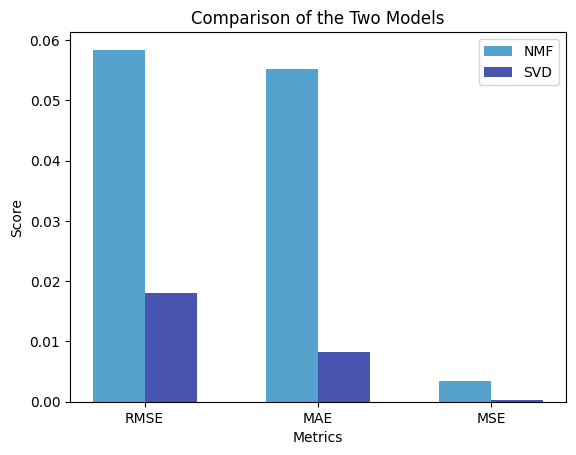

In [260]:
nmf_scores = [nmf_rmse, nmf_mae, nmf_rse]
svd_scores = [svd_rmse, svd_mae, svd_mse]

# Create a bar chart
bar_width = 0.3
index = [0, 1, 2]
plt.bar(index, nmf_scores, bar_width, label='NMF')
plt.bar([i + bar_width for i in index], svd_scores, bar_width, label='SVD')

# Add labels and title
plt.xticks([i + bar_width/2 for i in index], ['RMSE', 'MAE', 'MSE'])
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Comparison of the Two Models")
plt.legend()

# Show the chart
plt.show()

We select the SVD as our final model since the RMSE and RSE is lower than those numbers of NMF model.
We will return the full trainset.


In [261]:
trainset_full = customer_data.build_full_trainset()


Then we will build a full model using the full trainset


In [262]:
final_model = SVD(n_factors=10, n_epochs=50)
final_model.fit(trainset_full)


In [263]:
pickle.dump(final_model, open('collaborative_model.sav', 'wb'))
final_model = pickle.load(open('collaborative_model.sav', 'rb'))


## 2. Content-based Image-based Filtering approach




### 2.1. Methodology:

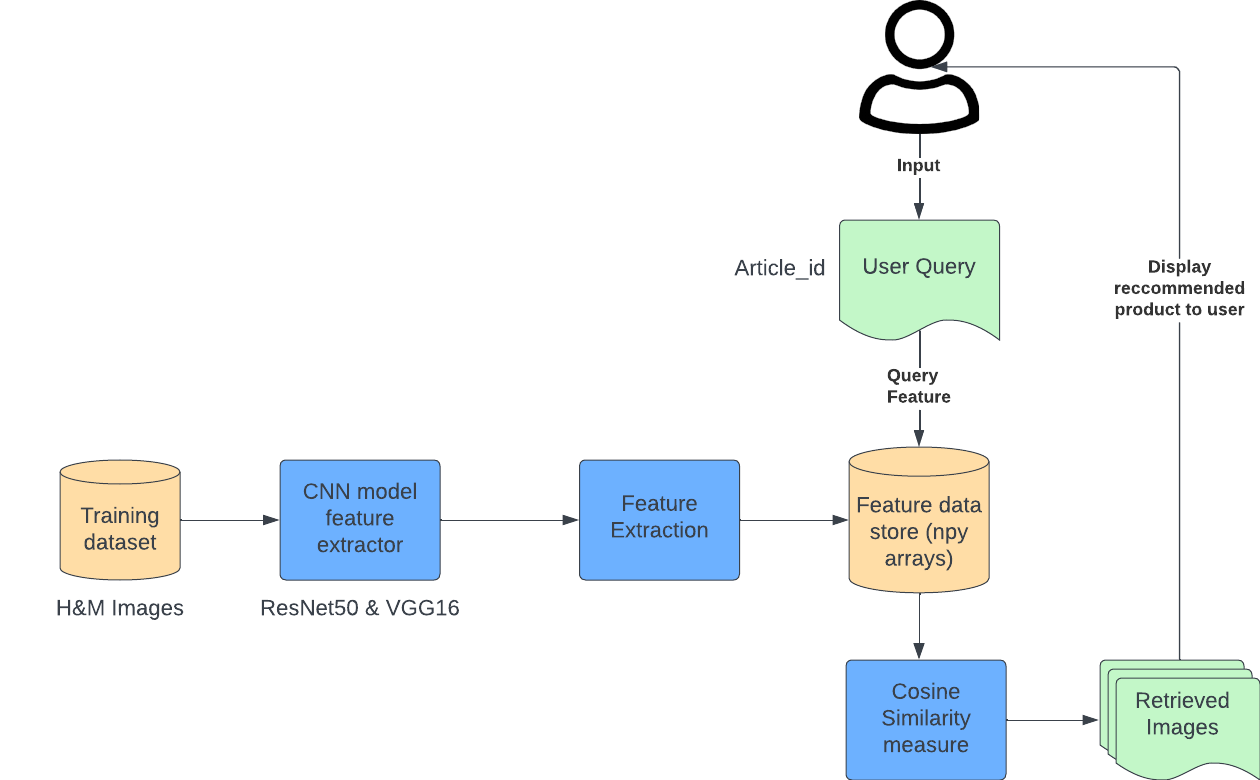

The flowchart above shows how the image-based recommender system is architected. The training dataset is the raw image dataset that has been grouped into sub-folders. Then we will fit the dataset into CNN models in order to extract features from each. Since there are 2 CNN models utilized, there are two sets of image matrices generated. These features are stored in a NumPy array for later usage in the recommender system. 

After that, we built a recommender system that takes in an article_id as an input that will be mapped to its image vector in the features store. User-input image features will then be compared with other features in the same category to get the most similar ones. 

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. It is a widely used similarity measure in various fields, including natural language processing, information retrieval, and computer vision. In this case, cosine similarity is used to find the most visually similar images to the user input images and recommend those images to users. The cosine similarity is calculated using image features of the input image, and other features, then get the top number of products that users might be interested in.

### 2.2. Data Pre-processing


#### 2.2.1. Downscale images and carry out metadata-based image grouping


Raw images memory is about ~1000kb, which is a very good image for viewing but a very computationally expensive image to fit into CNN models. Therefore, they are downscaled to only 224 x 224 pixels dimension, which is the appropriate data format for Keras CNN models like ResNet and VGG to train.

In [264]:
# # Set the input directory
# input_dir = 'downscaled_images_raw/'

# # Set the output directory
# output_dir = 'downscaled_images_structure/'

# # # Get a list of the images in the input directory
# image_folders = os.listdir(input_dir)

# # # Iterate over the images
# for folder in image_folders:
#     image_filenames = os.listdir(input_dir+folder)
#     for filename in image_filenames:
#         # Load the image
#         image = cv2.imread(input_dir + folder + "/" + filename)

#         folder_name = small_articles_df[small_articles_df['article_id'] == int(
#             filename[0:10])]["index_group_name"].values[0]
#         # Downscale the image using linear interpolation
#         downscaled_image = cv2.resize(
#             image, (224, 224), interpolation=cv2.INTER_LINEAR)
#         # Save the downscaled image to a file
#         cv2.imwrite(output_dir+folder_name+"/" +
#                     "Images/" + filename, downscaled_image)


### 2.3. Feature Engineering


<b>Feature extraction through 2 steps:</b><br>
- Image Augmentation using ImageDataGenerator to increase the overall generality of the CNN model
- Feature Extraction which output the feature maps for each image
- Save the maps into numpy arrays


In [279]:
# # index_group_name values
# train_data_groups = ["Children", "Divided",
#                      "Ladieswear", "Menswear", "Sport"]

# epochs = 50
# batch_size = 1


# def extract_features(group, model, model_name):
#     # empty array to store article_id
#     article_ids = []
#     datagen = ImageDataGenerator(rescale=1. / 255)
    
#     # image subfolers path
#     dir_path = "downscaled_images_structure/"+group+'/'
#     # image data augmentation
#     generator = datagen.flow_from_directory(
#         dir_path,
#         target_size=(224, 224),
#         batch_size=batch_size,
#         class_mode=None,
#         shuffle=False)
    
#     # add files names as article_id array
#     for i in generator.filenames:
#         article_ids.append(i[(i.find("/")+1):i.find(".")])
#     extracted_features = model.predict(
#         generator, len(generator.filenames) // batch_size)
    
#     extracted_features = extracted_features.reshape(
#         (len(generator.filenames), -1))
    
    
#     # save extracted features
#     np.save(open('./ResNet_{group}_{model_name}_features.npy'.format(
#         group=group, model_name=model_name), 'wb'), extracted_features)
#     np.save(open('./ResNet_{group}_{model_name}_feature_product_ids.npy'.format(
#         group=group, model_name=model_name), 'wb'),
#             np.array(article_ids))


#### 2.3.1. Resnet50 For Feature Extraction

Here we use 2 models ResNet50 and VGG16 to conduct feature extractions, which means we will have 2 sets of features maps.

In [266]:
# resnet_model = applications.ResNet50(
#         include_top=False, weights='imagenet')
  
# for image_group in train_data_groups:
#     extract_features(image_group,resnet_model, "ResNet50" )

In [267]:
# import ssl


# ssl._create_default_https_context = ssl._create_unverified_context
# resnet_model = applications.VGG16(
#         include_top=False, weights='imagenet')
  
# for image_group in train_data_groups:
#     extract_features(image_group,resnet_model, "VGG16" )


#### 2.3.2. Load the feature separators


Reload the Features that we have generated separately.

In [268]:
# ResNet50 generated features
children_extracted_features = np.load('ResNet_Children_features.npy')
children_Productids = np.load('ResNet_Children_feature_product_ids.npy')
divided_extracted_features = np.load(
    './ResNet_Divided_features.npy')
divided_Productids = np.load('./ResNet_Divided_feature_product_ids.npy')
menswear_extracted_features = np.load(
    './ResNet_Menswear_features.npy')
menswear_Productids = np.load(
    './ResNet_Menswear_feature_product_ids.npy')
ladieswear_extracted_features = np.load(
    './ResNet_Ladieswear_features.npy')
ladieswear_Productids = np.load(
    './ResNet_Ladieswear_feature_product_ids.npy')
sport_extracted_features = np.load('./ResNet_Sport_features.npy')
sport_Productids = np.load(
    './ResNet_Sport_feature_product_ids.npy')

VGG16_children_extracted_features = np.load('ResNet_Children_VGG16_features.npy')
VGG16_children_Productids = np.load('ResNet_Children_VGG16_feature_product_ids.npy')
VGG16_divided_extracted_features = np.load(
    './ResNet_Divided_VGG16_features.npy')
VGG16_divided_Productids = np.load('./ResNet_Divided_VGG16_feature_product_ids.npy')
VGG16_menswear_extracted_features = np.load(
    './ResNet_Menswear_VGG16_features.npy')
VGG16_menswear_Productids = np.load(
    './ResNet_Menswear_VGG16_feature_product_ids.npy')
VGG16_ladieswear_extracted_features = np.load(
    './ResNet_Ladieswear_VGG16_features.npy')
VGG16_ladieswear_Productids = np.load(
    './ResNet_Ladieswear_VGG16_feature_product_ids.npy')
VGG16_sport_extracted_features = np.load('./ResNet_Sport_VGG16_features.npy')
VGG16_sport_Productids = np.load(
    './ResNet_Sport_VGG16_feature_product_ids.npy')

What a feature map of an image looks like.

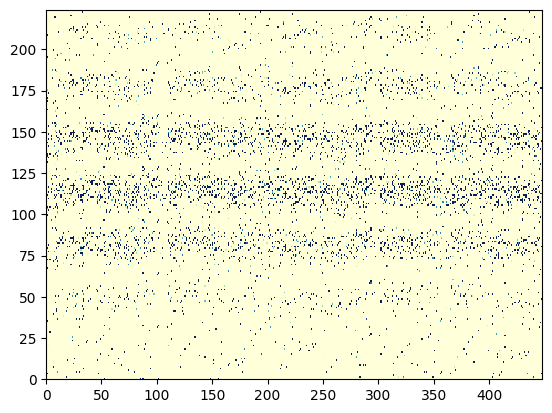

In [300]:
fig, ax = plt.subplots()
ax.pcolormesh(children_extracted_features[0].reshape(224, 448),  vmax=.3,  cmap="YlGnBu")

plt.show()



#### 2.3.3. Load Features


Return extracted Features and Id arrays dependent on the model and index_group_name.

In [270]:
def get_extracted_features_resnet(product_id):
    if (small_articles_df[small_articles_df['article_id'] == int(product_id)].empty):
        print(
            small_articles_df[small_articles_df['article_id'] == int(product_id)])
        return "No item matched input Id"
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Children"):
        extracted_features = children_extracted_features
        article_ids = children_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Divided"):
        extracted_features = divided_extracted_features
        Prarticle_idsoductids = divided_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Menswear"):
        extracted_features = menswear_extracted_features
        article_ids = menswear_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Ladieswear"):
        extracted_features = ladieswear_extracted_features
        article_ids = ladieswear_Productids
    else:
        extracted_features = sport_extracted_features
        article_ids = sport_Productids
    return extracted_features, article_ids

def get_extracted_features_VGG16(product_id):
    if (small_articles_df[small_articles_df['article_id'] == int(product_id)].empty):
        print(
            small_articles_df[small_articles_df['article_id'] == int(product_id)])
        return "No item matched input Id"
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Children"):
        extracted_features = VGG16_children_extracted_features
        article_ids = VGG16_children_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Divided"):
        extracted_features = VGG16_divided_extracted_features
        article_ids = VGG16_divided_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Menswear"):
        extracted_features = VGG16_menswear_extracted_features
        article_ids = VGG16_menswear_Productids
    elif (small_articles_df[small_articles_df['article_id'] == int(product_id)]['index_group_name'].values[0] == "Ladieswear"):
        extracted_features = VGG16_ladieswear_extracted_features
        article_ids = VGG16_ladieswear_Productids
    else:
        extracted_features = VGG16_sport_extracted_features
        article_ids = VGG16_sport_Productids
    return extracted_features, article_ids


#### 2.3. Build content-based image-based recommendation system


In [301]:
# display a single image
def display_image(path):
    img = Image.open(path)
    display(img)

In [272]:
def get_similar_products_cnn(product_id, num_results, model):

    extracted_features, article_ids = get_extracted_features_VGG16(
        product_id) if model == "VGG16" else get_extracted_features_resnet(product_id)

    # list of all article_ids
    Productids = list(article_ids)

    # index of the input article_id in the product list
    input_article_id_idx = Productids.index(product_id)

    ''' 
    calculate cosine sim score 
    from the feature of the 
    input image with others features  
    '''
    cosine_sim = cosine_similarity(
        extracted_features, extracted_features[input_article_id_idx].reshape(1, -1))
    
    # sort indices and sim score to get the most similar ones
    indices = np.argsort(cosine_sim.flatten())[::-1][0:num_results]
    similarities = np.sort(cosine_sim.flatten())[::-1][0:num_results]

    print("="*20, "input product details", "="*20)
    
    # path of input image
    input_row = small_articles_df[small_articles_df['article_id'] == int(
        Productids[indices[0]])]
    
    # path of input image
    input_img_path = "downscaled_images_structure/" + \
        input_row['index_group_name'].values[0]+"/Images/" + \
        "0"+str(input_row["article_id"].values[0])+".jpg"
    display_image(input_img_path)
    print('Product Title: ', input_row['prod_name'])
    print('Product Type: ', input_row['product_type_name'])
    print('Product Graphical Appearance: ', input_row['graphical_appearance_name'])
    print("\n", "="*20, "Recommended products", "="*20)
    
    # display top similar images with highest cosine similarity score
    for i in range(1, len(indices)):
        # get metatdata
        rows = small_articles_df[small_articles_df['article_id'] == int(
            Productids[indices[i]])]
        # display images
        for indx, row in rows.iterrows():
            rec_img_path = "downscaled_images_structure/" + \
                row['index_group_name'] + "/Images/0" + \
                str(row["article_id"])+".jpg"
            display_image(rec_img_path)
            print('Product Title: ', row['prod_name'])
            print('Product Type: ', row['product_type_name'])
            print('Product Graphical Appearance: ', row['graphical_appearance_name'])
            
            print('Cosine similarity score:', similarities[i])


### Recommender using VGG16 Features

==================== input product details ====================


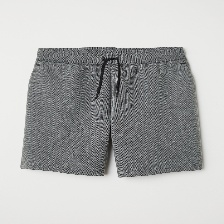

Product Title:  6773    Tom shorts (1)
Name: prod_name, dtype: object
Product Type:  6773    Shorts
Name: product_type_name, dtype: object
Product Graphical Appearance:  6773    Melange
Name: graphical_appearance_name, dtype: object

 ==================== Recommended products ====================


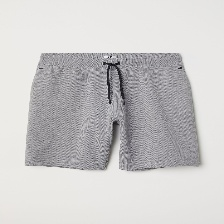

Product Title:  Tom shorts
Product Type:  Shorts
Product Graphical Appearance:  Melange
Cosine similarity score: 0.9687715


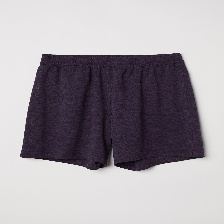

Product Title:  HAL SHORTS
Product Type:  Shorts
Product Graphical Appearance:  Melange
Cosine similarity score: 0.9536843


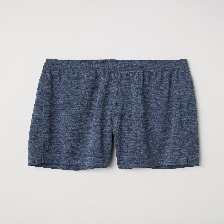

Product Title:  HAL SHORTS
Product Type:  Shorts
Product Graphical Appearance:  Melange
Cosine similarity score: 0.9534896


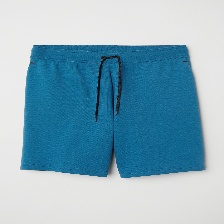

Product Title:  Tom shorts
Product Type:  Shorts
Product Graphical Appearance:  Solid
Cosine similarity score: 0.95304996


In [273]:
get_similar_products_cnn('0508640007', 5, "VGG16")


### Recommender using ResNet50 Features

==================== input product details ====================


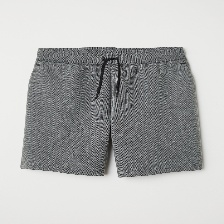

Product Title:  6773    Tom shorts (1)
Name: prod_name, dtype: object
Product Type:  6773    Shorts
Name: product_type_name, dtype: object
Product Graphical Appearance:  6773    Melange
Name: graphical_appearance_name, dtype: object

 ==================== Recommended products ====================


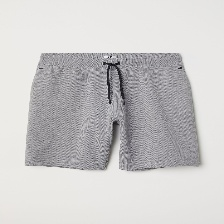

Product Title:  Tom shorts
Product Type:  Shorts
Product Graphical Appearance:  Melange
Cosine similarity score: 0.99867934


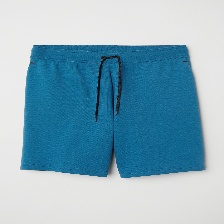

Product Title:  Tom shorts
Product Type:  Shorts
Product Graphical Appearance:  Solid
Cosine similarity score: 0.9986192


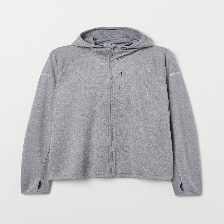

Product Title:  Roman running hood
Product Type:  Hoodie
Product Graphical Appearance:  Melange
Cosine similarity score: 0.99730575


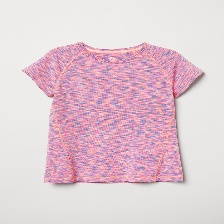

Product Title:  KATE TEE
Product Type:  T-shirt
Product Graphical Appearance:  Melange
Cosine similarity score: 0.9972657


In [274]:
get_similar_products_cnn('0508640007', 5, "ResNet50")

### Additional Trial: Kmeans Method

/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress t

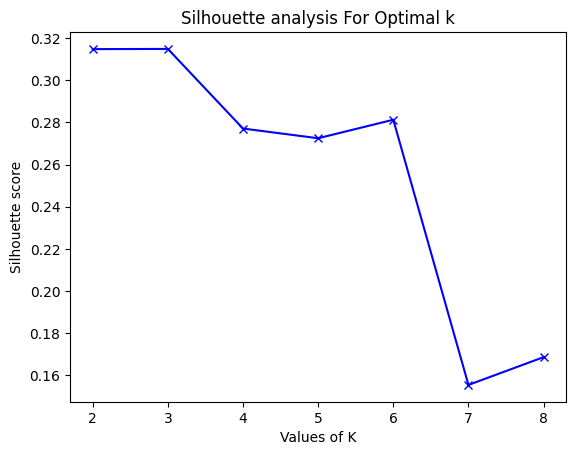

In [275]:
extracted_features, _ = get_extracted_features_resnet('0519975002')
Sum_of_squared_distances = []
silhouette_avg = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(extracted_features)
    cluster_labels = kmeans.labels_
    silhouette_avg.append(silhouette_score(extracted_features, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of K") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()


In [276]:
from sklearn.cluster import KMeans


def get_similar_products_cnn_clustering(product_id, num_results):
    extracted_features, Productids = get_extracted_features_resnet(product_id)
    Productids = list(Productids)

    # fit kmeans model on extracted features
    kmeans = KMeans(n_clusters=6,
                    random_state=42).fit(extracted_features)

    # get the cluster index of the input product
    doc_id = Productids.index(product_id)
    input_product_cluster = kmeans.labels_[doc_id]

    # get the indices of the products in the same cluster as the input product
    indices = np.where(kmeans.labels_ == input_product_cluster)[0]

    print("="*20, "input product details", "="*20)
    ip_row = small_articles_df[small_articles_df['article_id'] == int(
        Productids[indices[0]])]

    img = Image.open("downscaled_images_structure/" +
                     ip_row['index_group_name'].values[0]+"/Images/" + "0"+str(ip_row["article_id"].values[0])+".jpg")
    display(img)

    print('Product Title: ', ip_row['prod_name'])
    print("\n", "="*20, "Recommended products", "="*20)
    counter = 0
    for i in range(1, len(indices)):
        rows = small_articles_df[small_articles_df['article_id'] == int(
            Productids[indices[i]])]
        for indx, row in rows.iterrows():
            if counter < num_results:
                img = Image.open("downscaled_images_structure/" +
                                 row['index_group_name'] +
                                 "/Images/0" + str(row["article_id"])+".jpg")
                display(img)
                print('Product Title: ', row['prod_name'])
                counter += 1
            else:
                break


/Users/giangnguyen/Library/Python/3.10/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


==================== input product details ====================


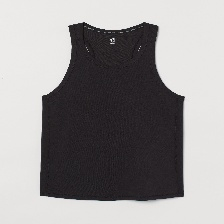

Product Title:  1607    Miami tanktop
Name: prod_name, dtype: object

 ==================== Recommended products ====================


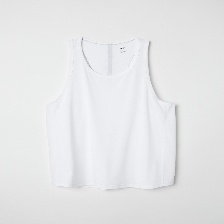

Product Title:  Miami tanktop


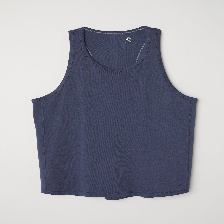

Product Title:  Miami tanktop


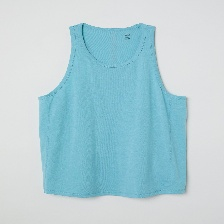

Product Title:  Miami tanktop


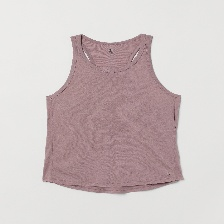

Product Title:  Miami tanktop


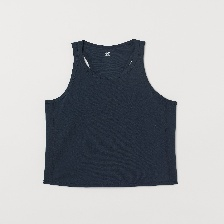

Product Title:  Miami tanktop


In [277]:
get_similar_products_cnn_clustering('0498740011', 5)
